In [178]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from tqdm import tqdm
from PIL import Image, ImageDraw, ImageFont
import pandas as pd
import numpy as np
import cv2
import os
from skimage.morphology import convex_hull_image, binary_closing, square, dilation
from scipy import ndimage

In [179]:
#  load all images from a directory
def load_images_from_folder(folder):
    images = []
    filenames = []
    for filename in tqdm(os.listdir(folder)):
        try:
            img = Image.open(os.path.join(folder,filename))
            if img is not None:
                if img.mode != 'RGB':
                    img = img.convert('RGB')
                img = np.array(img)
                images.append(img)
                filenames.append(filename)
        except Exception as e:
            print(e)
    return images, filenames

In [180]:
# load all jsons from a directory
def load_jsons_from_folder(folder):
    jsons = []
    filenames = []
    for filename in tqdm(os.listdir(folder)):
        try:
            json = pd.read_json(os.path.join(folder,filename))
            if json is not None:
                jsons.append(json)
                filenames.append(filename)
        except Exception as e:
            print(e)
    return jsons, filenames

In [181]:
LOAD_CLEAN = False
if LOAD_CLEAN:
    human_parsing = load_images_from_folder('Task/dataset/human_parsing')
    image = load_images_from_folder('Task/dataset/image')
    pose_json = load_jsons_from_folder('Task/dataset/pose_json')
    pose_img = load_images_from_folder('Task/dataset/pose_img')
    df = pd.DataFrame()
    df['human_parsing'] = human_parsing[0]
    df['image'] = image[0]
    df['pose_json'] = pose_json[0]
    df['pose_img'] = pose_img[0]
    df['ids'] = [a.split('.')[0] for a in image[1]]
    df['pose_keypoints'] = df.pose_json.apply(lambda x: x.people[0].get('pose_keypoints_2d'))
    left_ankles = [a[3*11:3*12-1] for a in tqdm(df.pose_keypoints)]
    right_ankles = [a[3*14:3*15-1] for a in tqdm(df.pose_keypoints)]
    df['left_ankles'] = left_ankles
    df['right_ankles'] = right_ankles
    df.to_pickle('df.pkl')
else:
    df = pd.read_pickle('df.pkl')

In [182]:
def get_color_mask(img, colors):
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    for color in colors:
        mask += np.all(img == color, axis=-1).astype(np.uint8)
    return mask

def clean_outliers(mask):
    labels, num_labels = ndimage.label(mask)
    component_sizes = ndimage.sum(mask, labels, range(num_labels + 1))
    mask_largest_component = (labels == component_sizes.argmax())
    return mask_largest_component

def apply_mask(img, mask):
    img = np.array(img)
    img[mask] = (128, 128, 128)
    return Image.fromarray(img)

def ankle_mask(img, left_ankle, right_ankle):
    try:
        img = np.array(img)
        mask = np.zeros(img.shape[:2], dtype=np.uint8)
        x = [left_ankle[0], right_ankle[0]]
        y = [left_ankle[1], right_ankle[1]]
        m = (y[1] - y[0]) / (x[1] - x[0])
        b = y[0] - m * x[0]
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                if i > m * j + b:
                    mask[i, j] = 1
        return mask
    except Exception as e:
        print(e)
        return np.zeros(img.shape[:2], dtype=np.uint8)

In [183]:
short_colors = {(64, 0, 128), (192, 0, 0)}
legs_colors = {(128,64,0), (0,64,0)}

shirt_colors = {(128,0,128), (128,128,128), (128,64,128)}
hands_colors = {(192,128,128),(64,128,128)}

In [184]:
RENDER = True
if RENDER:
    tqdm._instances.clear()
    mask_shorts = [get_color_mask(a, short_colors) for a in tqdm(human_parsing[0])]
    mask_shorts_clean = [clean_outliers(a) for a in tqdm(mask_shorts)]
    mask_legs = [get_color_mask(a, legs_colors) for a in tqdm(human_parsing[0])]
    mask_shirts = [get_color_mask(a, shirt_colors) for a in tqdm(human_parsing[0])]
    mask_hands = [get_color_mask(a, hands_colors) for a in tqdm(human_parsing[0])]
    mask_ankle = [ankle_mask(a, b, c) for a, b, c in tqdm(zip(df.image, df.left_ankles, df.right_ankles))]

    
    df['mask_shorts'] = mask_shorts
    df['mask_legs'] = mask_legs
    df['mask_shirts'] = mask_shirts
    df['mask_hands'] = mask_hands
    df['mask_ankle'] = mask_ankle
    df.to_pickle('df_full.pkl')
else:
    df = pd.read_pickle('df_full.pkl')

KeyboardInterrupt: 

[271 323] (166.67574320573476, 908.3749964567105) (527.902295746223, 844.0773037414576) [567 592]


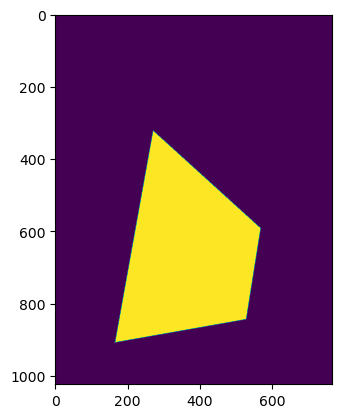

In [ ]:
shorts = df.mask_shorts[0]
left_ankle = df.left_ankles[0]
right_ankle = df.right_ankles[0]
image = df.image[0]

def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
       raise Exception('lines do not intersect')

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return x, y

def prolong_shorts(shorts, left_ankle, right_ankle):

    try:
        ankle_line = ((left_ankle[0], left_ankle[1]), (right_ankle[0], right_ankle[1]))

        indices = np.argwhere(shorts)
        highest_left_point = indices[np.argmin(indices.sum(axis=1))]
        lowest_left_point = indices[np.argmin(indices[:, 0])]
        left_line = ((highest_left_point[0], highest_left_point[1]), (lowest_left_point[0], lowest_left_point[1]))
        left_intersection = line_intersection(left_line, ankle_line)

        highest_right_point = indices[np.argmax(indices.sum(axis=1))]
        lowest_right_point = indices[np.argmax(indices[:, 0])]
        right_line = ((highest_right_point[0], highest_right_point[1]), (lowest_right_point[0], lowest_right_point[1]))
        right_intersection = line_intersection(right_line, ankle_line)

        print(highest_left_point, left_intersection, right_intersection, highest_right_point)
        # draw poligon from points highest_left_point, left_intersection, right_intersection, highest_right_point
        # use pillow (pil)
        mask = Image.fromarray(np.zeros(shorts.shape, dtype=np.uint8))
        draw = ImageDraw.Draw(mask)
        draw.polygon([tuple(highest_left_point), tuple(left_intersection), tuple(right_intersection), tuple(highest_right_point)], outline=1, fill=1)
        mask = np.array(mask)

        return mask
    except:
        return None

# imshow(prolong_shorts(image, shorts, ankle_line))
imshow(prolong_shorts(shorts, left_ankle, right_ankle))

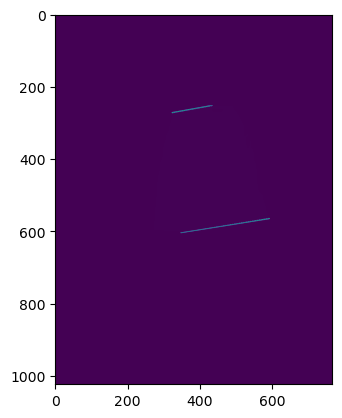

In [ ]:
imshow(shorts)

In [ ]:
tqdm._instances.clear()
mask_prolonged_shorts = [prolong_shorts(a, b, c) for a, b, c in tqdm(zip(df.mask_shorts, df.left_ankles, df.right_ankles))]

704it [00:05, 134.54it/s]


In [ ]:
df['mask_prolonged_shorts'] = mask_prolonged_shorts

In [ ]:
# save processed_images to /preprocessed
SAVE_PROCESSED = True
if SAVE_PROCESSED:
    for i, img in tqdm(enumerate(processed_images_withankles)):
        img.save('C:/code/python/test_task_big/preprocessed_6/' + df.ids[i] + '.jpg')

704it [00:08, 87.11it/s] 


In [ ]:
img_cols = set(df.columns) - set(['ids', 'pose_keypoints', 'pose_json'])
img_cols = [
    'image',
    'human_parsing',
    'pose_img',
    'mask_shorts',
    'mask_legs',
    'mask_legs_and_shorts',
    'mask_shirts',
    'mask_hands',
    'mask_upper_body',
    'mask_skirts_clean',
    'mask_skirts_clean_no_outliers',
    'mask_skirts_clean_convex',
    'mask_skirts_final',
    'mask_ankle'
    'processed_images',
    'processed_images_ankles'
 ]

In [ ]:
def show_images_df(df, cols, index, save=False):
    fig, axes = plt.subplots(1, len(cols), figsize=(20, 20))
    for i, col in enumerate(cols):
        axes[i].imshow(df[col][index])
        axes[i].set_title(col)
    if save:
        fig.savefig('full_outs/' + df.ids[index] + '.jpg')
    else:
        plt.show()

In [ ]:
img_cols = ['mask_ankle', 'processed_images', 'processed_images_ankles', 'mask_shorts', 'human_parsing', 'mask_skirts_clean', 'mask_skirts_clean_no_outliers', 'mask_prolonged_shorts']

In [ ]:
df[df.ids.str.contains('168764')].index

Int64Index([1], dtype='int64')

In [ ]:
df[df.ids.str.contains('178842')].index

Int64Index([229], dtype='int64')

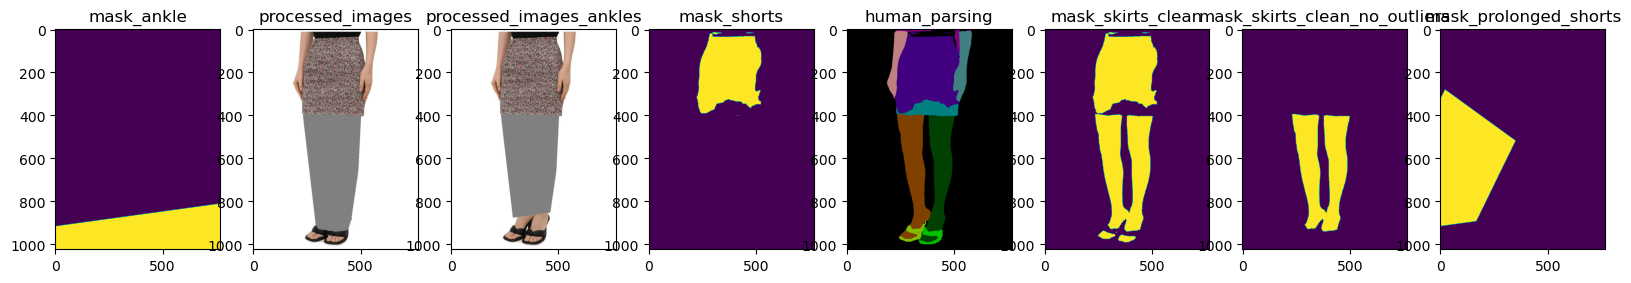

In [ ]:
show_images_df(df, img_cols, 229)

In [ ]:
# HELPER FUNCTIONS
# def draw_pose(img, poses):
#     draw = ImageDraw.Draw(img)
#     for i in range(0, len(poses), 3):
#         draw.ellipse((poses[i]-5, poses[i+1]-5, poses[i]+5, poses[i+1]+5), fill=(255, 0, 0, 255))
#         draw.text((poses[i], poses[i+1]), str(i//3), fill=(255, 0, 0, 0), font= ImageFont.truetype("arial.ttf", 30))
#     return img
# draw_pose(df.image[0], df.pose_keypoints[0])

